In [1]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [2]:
# MODEL IMAGES PATHS
path_to_vgg16_model_image = "model_images/vgg16.png"

# MODEL WEIGHTS PATHS
# set always net path for weights
path_to_vgg16_model_weights = "./vgg16_weights/vgg16_model_weights"

# CSV LOGS PATHS
path_to_vgg16_csvlog = "./csv_logs/vgg16"

# JSON MODEL PRESENTATION PATHS
vgg16_model_json_path = "./json_models/vgg16.json"

# MODEL PATHS
path_to_vgg16_model = "./models/vgg16"


# Number of epochs hyperparameter
num_of_epochs = 50

In [3]:
RANDOM_STATE = 1234

In [4]:
# PATH TO FOOD IMAGES
beans = 'images/BEANS'
cake = 'images/CAKE'
candy = 'images/CANDY'
cereal = 'images/CEREAL'
chips = 'images/CHIPS'
chocolate = 'images/CHOCOLATE'
coffee = 'images/COFFEE'
corn = 'images/CORN'
fish = 'images/FISH'
flour = 'images/FLOUR'
honey = 'images/HONEY'
jam = 'images/JAM'
juice = 'images/JUICE'
milk = 'images/MILK'
nuts = 'images/NUTS'
oil = 'images/OIL'
pasta = 'images/PASTA'
rice = 'images/RICE'
soda = 'images/SODA'
spices = 'images/SPICES'
sugar = 'images/SUGAR'
tea = 'images/TEA'
tomato_sauce = 'images/TOMATO_SAUCE'
vinegar = 'images/VINEGAR'
water = 'images/WATER'

X = []
Z = []
imgsize = 150

In [5]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
def print_model(model, model_name):
    plot_model(model, to_file = model_name, show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
# VGG16 arhitecture
def vgg16_model(img_rows,img_cols):
    base_model = VGG16(include_top=False,
                      input_shape = (img_rows,img_cols,3),
                      weights = 'imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(3072,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [8]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [9]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in classes_names],
                  columns = [i for i in classes_names])
    plt.figure(figsize = (16,12))
    plt.title(conf_matrix_name)
    sn.heatmap(df_cm, annot=True)
    plt.savefig('./confusion_matrices/' + conf_matrix_name)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

In [10]:
def write_model_as_json(model, path):
    model_json = model.to_json()
    with open(path,"w") as json_file:
        json_file.write(model_json)

In [11]:
# INITIAL CNN MODEL

# model = Sequential([
#     Input(shape=input_shape),
#     Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(number_of_classes, activation='softmax')
# ])

# model.summary()
# display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))
# model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# batch_size = 128
# epochs = 12
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2)

In [12]:
def test_model():
    model = Sequential([
        Input(shape=(150,150,3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(25, activation='softmax')
    ])
    
    model.summary()
    return model

In [13]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:02<00:00, 130.80it/s]


In [14]:
# shape of image
X[0].shape

(150, 150, 3)

In [15]:
# image data format
K.image_data_format()

'channels_last'

In [16]:
len(X),len(Z)

(4947, 4947)

In [17]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [18]:
Y

array([ 0,  0,  0, ..., 24, 24, 24], dtype=int64)

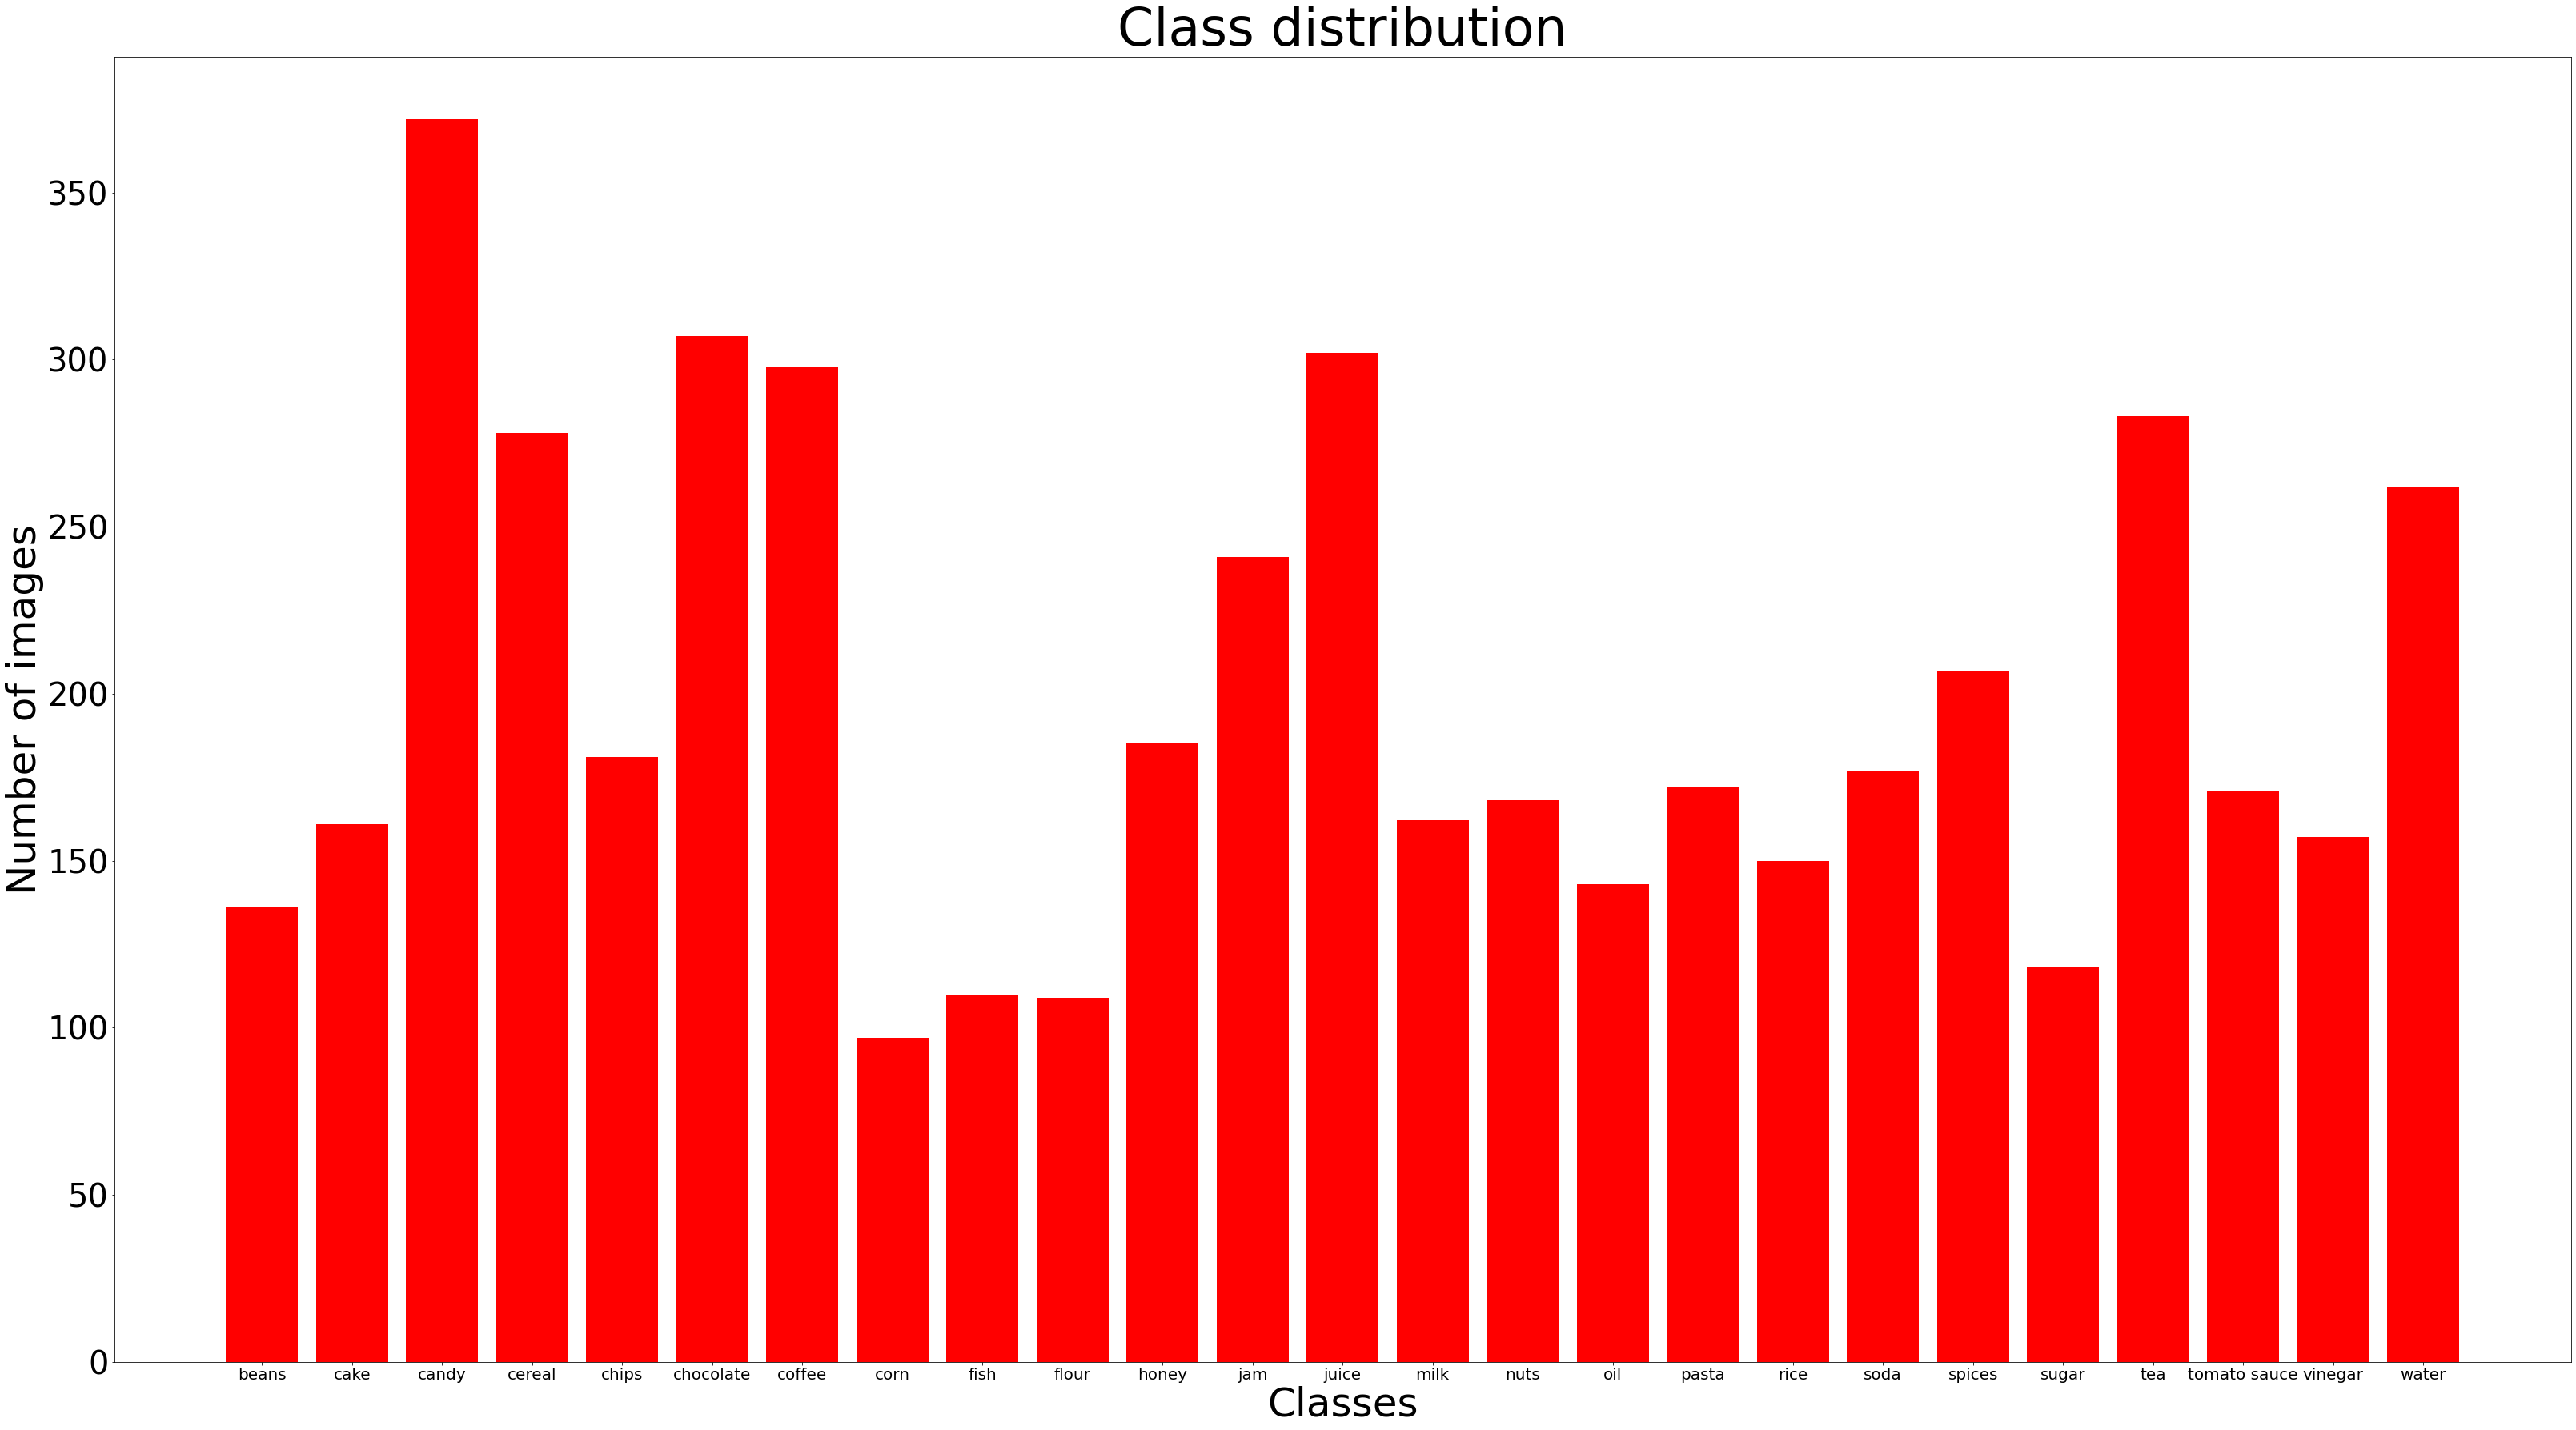

In [19]:
# bar diagram of class distribution
classes_names = ['beans','cake','candy','cereal','chips','chocolate','coffee','corn','fish','flour','honey',
                'jam','juice','milk','nuts','oil','pasta','rice','soda','spices','sugar','tea','tomato sauce','vinegar','water']
plt.figure(figsize=(55,30))
plt.title('Class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(Y), color = 'r')
plt.show()

In [20]:
Y = to_categorical(Y,25)

In [21]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [22]:
# data preprocessing
X = np.array(X)
X = preprocess_input(X)
# X = X.astype('float32')
# X=X/255

In [23]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [24]:
# train - test - val split
# x_train_val, x_test, y_train_val, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_STATE,stratify=Y)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=RANDOM_STATE,stratify=y_train_val)
# x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

# split only on x_train - y_train because we will use ImageDataGenerator on x_train for validation instances
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=RANDOM_STATE,stratify=Y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3462, 150, 150, 3), (1485, 150, 150, 3), (3462, 25), (1485, 25))

In [25]:
# CHECK IF X_TEST HAVE ALL CLASSES

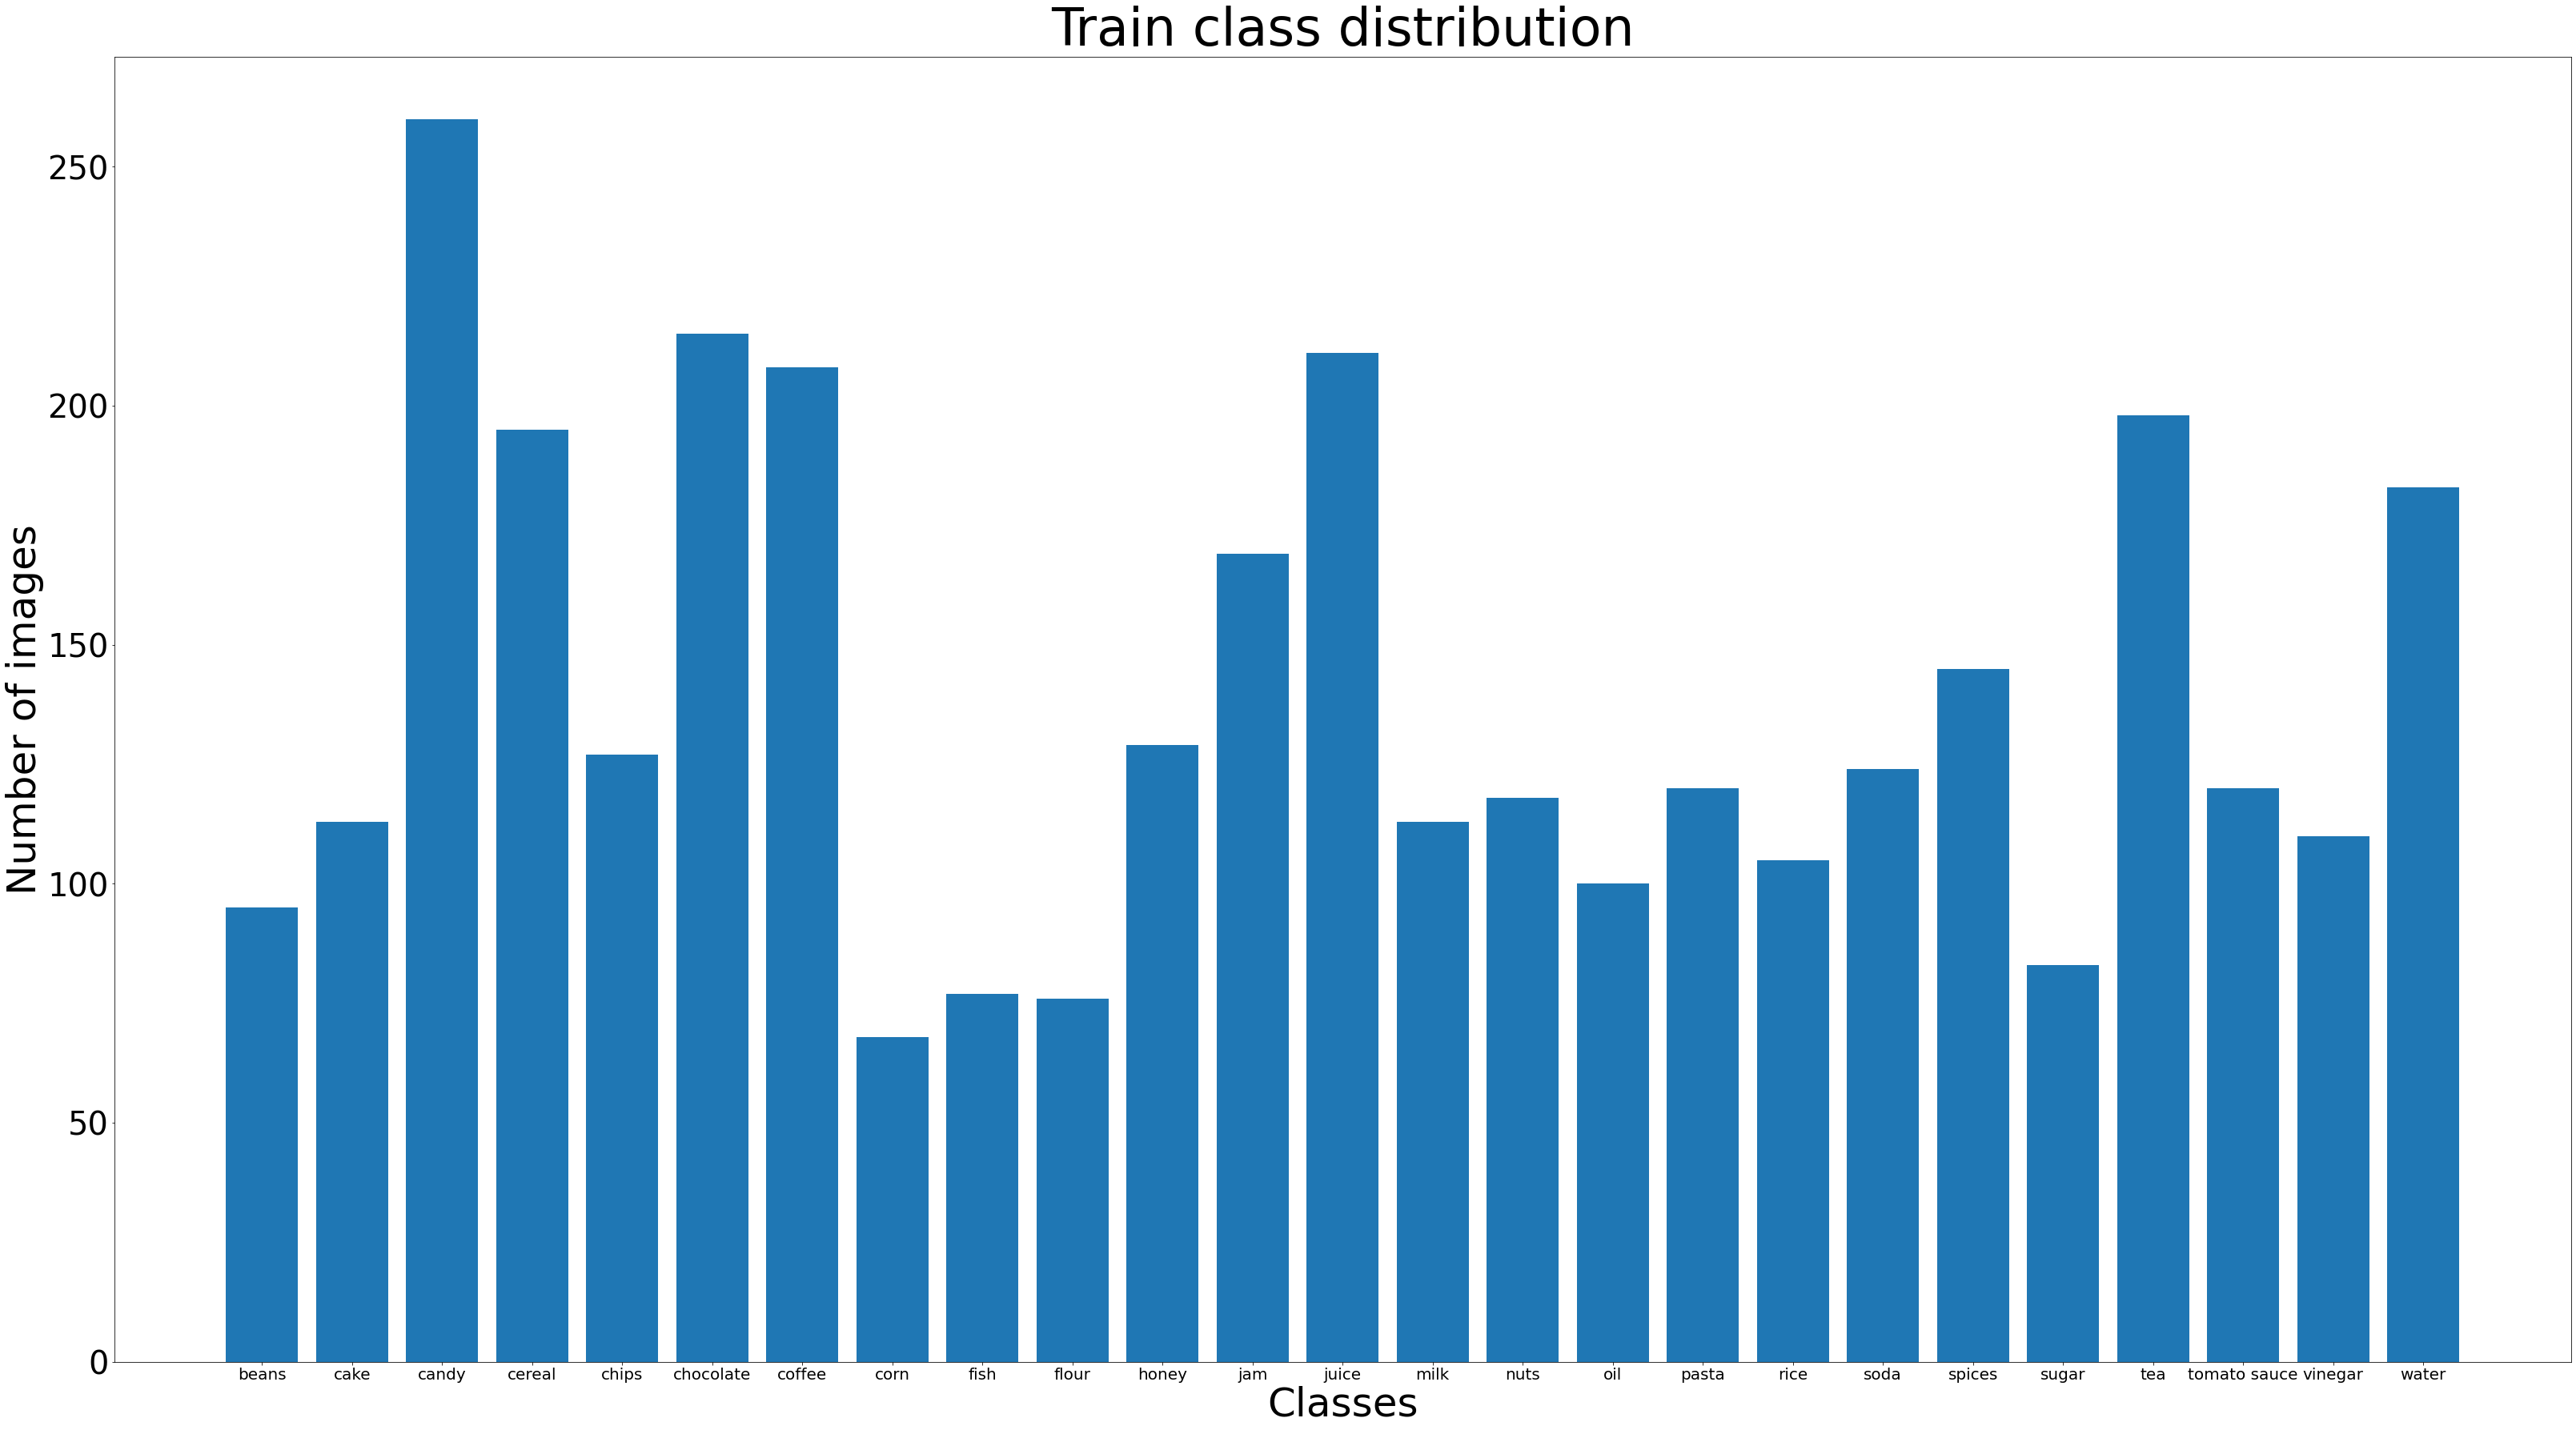

In [26]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_train_cls))
plt.show()

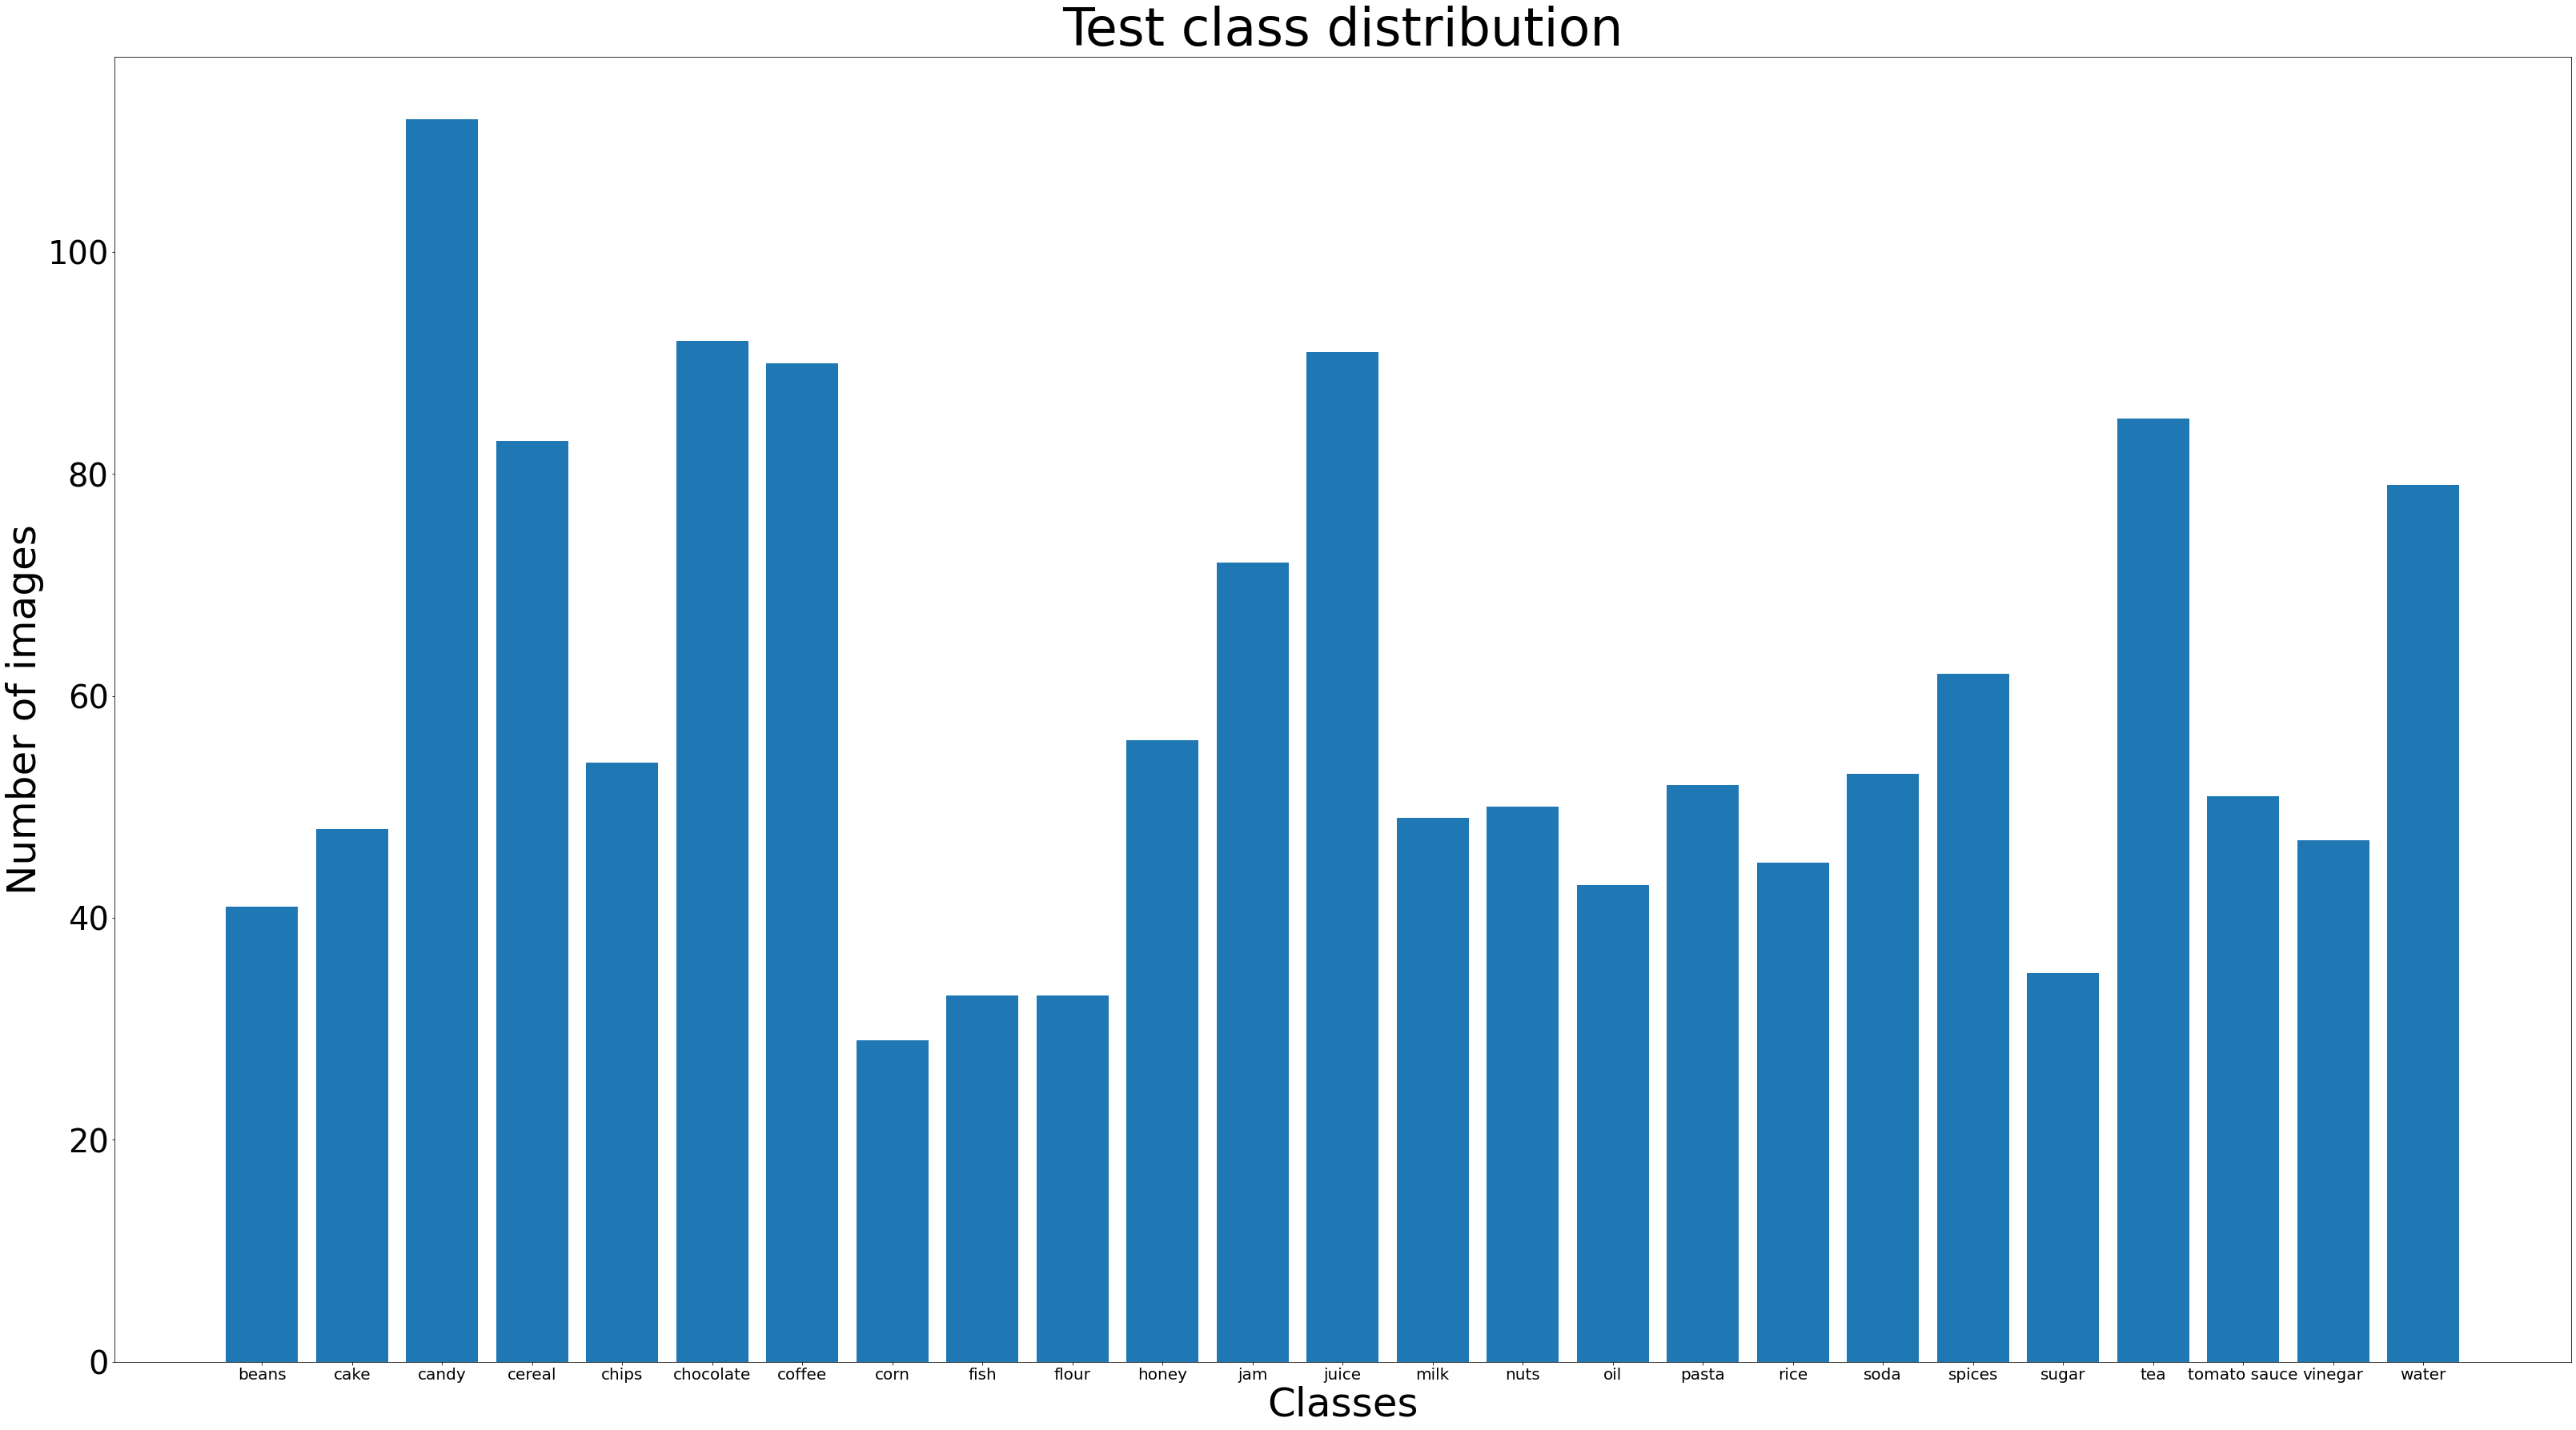

In [27]:
y_test_cls = np.argmax(y_test, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Test class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_test_cls))
plt.show()

In [28]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3) 

augs_gen.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

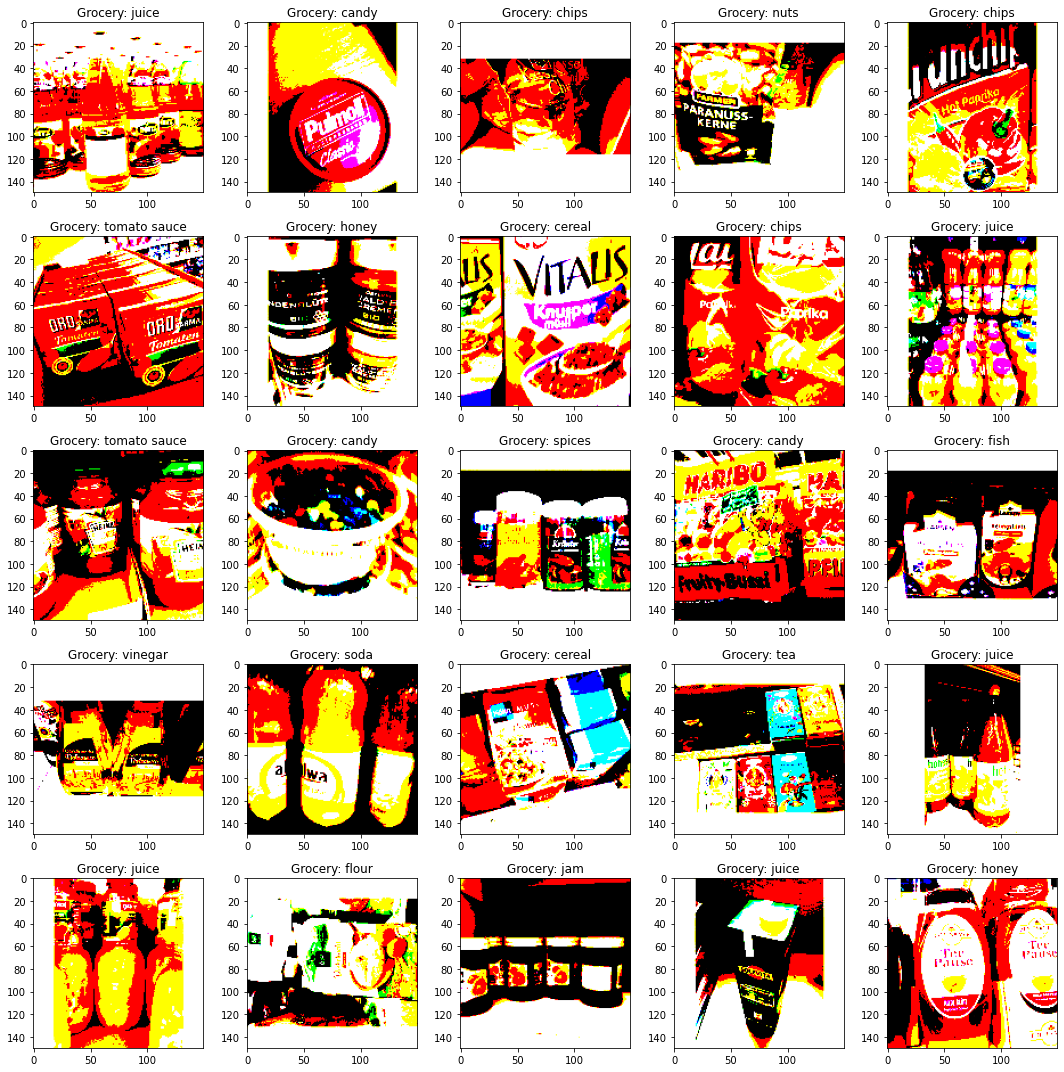

In [29]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        k = rn.randint(0, len(Z))
        ax[i,j].imshow(X[k])
        ax[i,j].set_title('Grocery: '+ Z[k])
        
plt.tight_layout()

In [30]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [31]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [32]:
# model = test_model()
model = vgg16_model(img_rows, img_cols)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002B2D0B5BC40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D2DB9760> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D2DB9F70> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B2D2618160> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D268C430> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D26918B0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B2D2618130> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D269D910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D26A4790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B2D26A4580> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B2D26A9DF0> False
<tensorflow.python.

In [33]:
print_model(model, path_to_vgg16_model_image)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [34]:
checkpoint = ModelCheckpoint(
    filepath=path_to_vgg16_model_weights,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)


csvlogger = CSVLogger(
    filename= path_to_vgg16_csvlog,
    separator = ",",
    append = False
)


# Reduce learning rate when a metric has stopped improving
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, csvlogger, reduce]

In [35]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
                    augs_gen.flow(x_train, y_train, batch_size = 32,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(x_train, y_train, batch_size=32, subset='validation'),
                    callbacks=callbacks
                    )

Epoch 1/50
76/76 [==============================] - 307s 4s/step - loss: 4.9239 - accuracy: 0.2715 - val_loss: 2.4367 - val_accuracy: 0.3998
Epoch 2/50
76/76 [==============================] - 293s 4s/step - loss: 1.8284 - accuracy: 0.5033 - val_loss: 1.9574 - val_accuracy: 0.4624
Epoch 3/50
76/76 [==============================] - 268s 4s/step - loss: 1.3535 - accuracy: 0.6093 - val_loss: 1.9140 - val_accuracy: 0.5019
Epoch 4/50
76/76 [==============================] - 264s 3s/step - loss: 1.1885 - accuracy: 0.6510 - val_loss: 1.9351 - val_accuracy: 0.5212
Epoch 5/50
76/76 [==============================] - 278s 4s/step - loss: 1.0617 - accuracy: 0.6745 - val_loss: 1.8544 - val_accuracy: 0.5289
Epoch 6/50
76/76 [==============================] - 282s 4s/step - loss: 0.9247 - accuracy: 0.7153 - val_loss: 1.9616 - val_accuracy: 0.5183
Epoch 7/50
76/76 [==============================] - 284s 4s/step - loss: 0.8496 - accuracy: 0.7347 - val_loss: 1.9432 - val_accuracy: 0.5222
Epoch 8/50
76

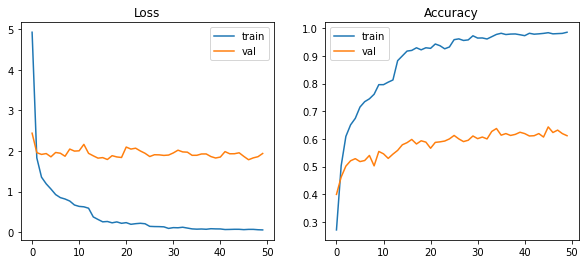

In [36]:
plot_acc_loss(history,num_of_epochs)

In [37]:
# MODEL EVALUATION

109/109 [==============================] - 274s 3s/step - loss: 0.6025 - accuracy: 0.8951
Test loss: 0.6024762988090515
Test accuracy: 0.8951473236083984
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        95
           1       0.88      0.88      0.88       113
           2       0.89      0.94      0.91       260
           3       0.85      0.90      0.88       195
           4       0.87      0.91      0.89       127
           5       0.91      0.84      0.87       215
           6       0.90      0.86      0.88       208
           7       0.86      0.87      0.86        68
           8       0.89      0.87      0.88        77
           9       0.91      0.84      0.88        76
          10       0.95      0.91      0.93       129
          11       0.91      0.96      0.93       169
          12       0.88      0.92      0.90       211
          13       0.89      0.91      0.90       113
          14       0.76      0.81  

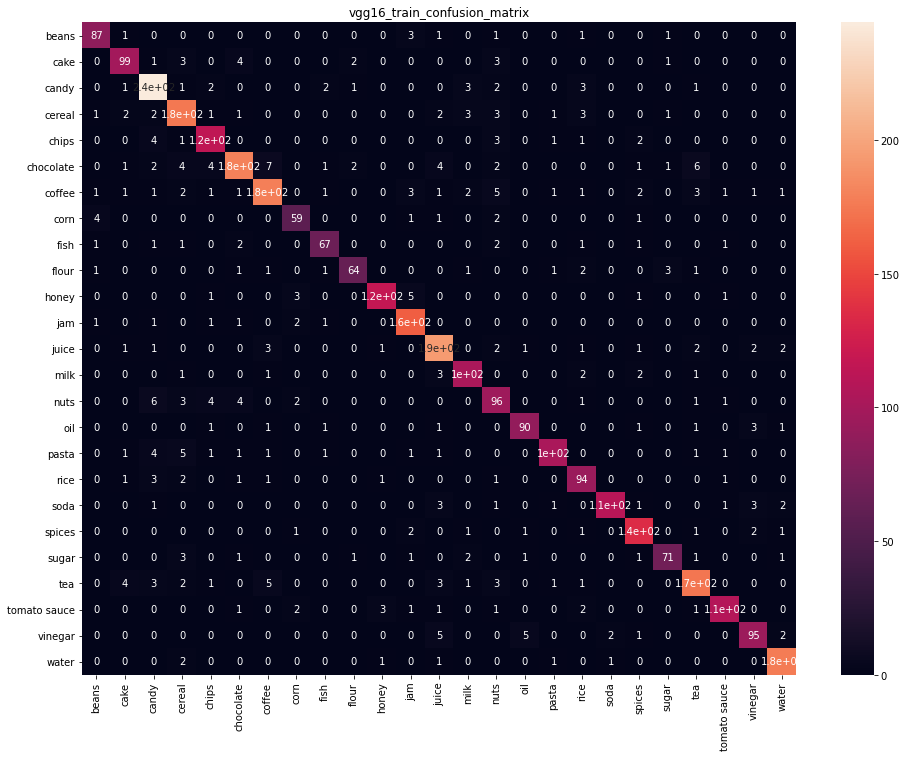

In [38]:
# TRAIN EVALUATION
evaluate_model(model,x_train,y_train,classes_names,"vgg16_train_confusion_matrix")

47/47 [==============================] - 110s 2s/step - loss: 1.8701 - accuracy: 0.6680
Test loss: 1.8700724840164185
Test accuracy: 0.6680134534835815
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        41
           1       0.71      0.60      0.65        48
           2       0.63      0.84      0.72       112
           3       0.64      0.70      0.67        83
           4       0.70      0.59      0.64        54
           5       0.65      0.55      0.60        92
           6       0.65      0.68      0.66        90
           7       0.56      0.52      0.54        29
           8       0.65      0.67      0.66        33
           9       0.58      0.55      0.56        33
          10       0.69      0.64      0.67        56
          11       0.71      0.85      0.77        72
          12       0.67      0.68      0.67        91
          13       0.59      0.71      0.65        49
          14       0.57      0.58    

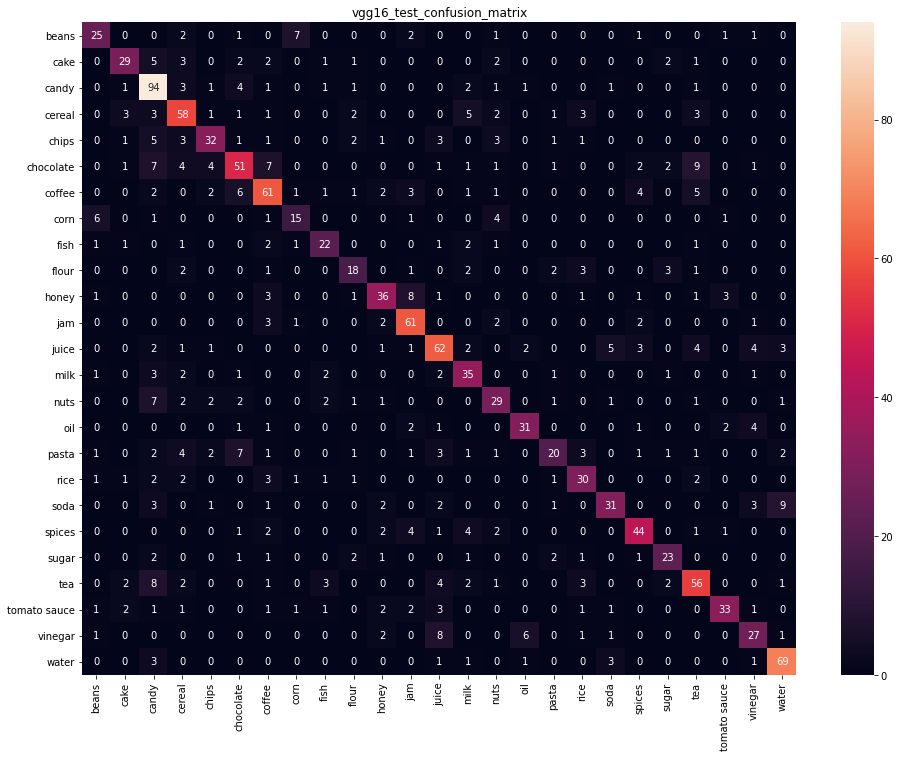

In [39]:
# TEST EVALUATION
evaluate_model(model,x_test,y_test,classes_names,"vgg16_test_confusion_matrix")

In [40]:
# take weights with max acc
# ret = model.load_weights(path_to_vgg1_model_weights)

In [41]:
# SAVING MODEL

In [42]:
write_model_as_json(model,vgg16_model_json_path)

In [43]:
model.save(path_to_vgg16_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/vgg16\assets


In [44]:
# model1 = load_model(path_to_vgg16_model)

In [45]:
# evaluate_model(model1,x_test,y_test,classes_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


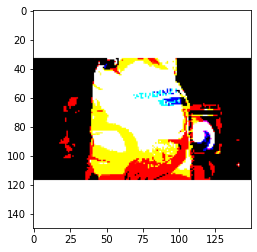

In [46]:
plt.imshow(x_test[12])
plt.show()

In [47]:
np.argmax(y_test[12])

9

In [48]:
classes_names[9]

'flour'

In [49]:
np.argmax(model.predict(x_test[12:13]))

9

In [50]:
classes_names[9]

'flour'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

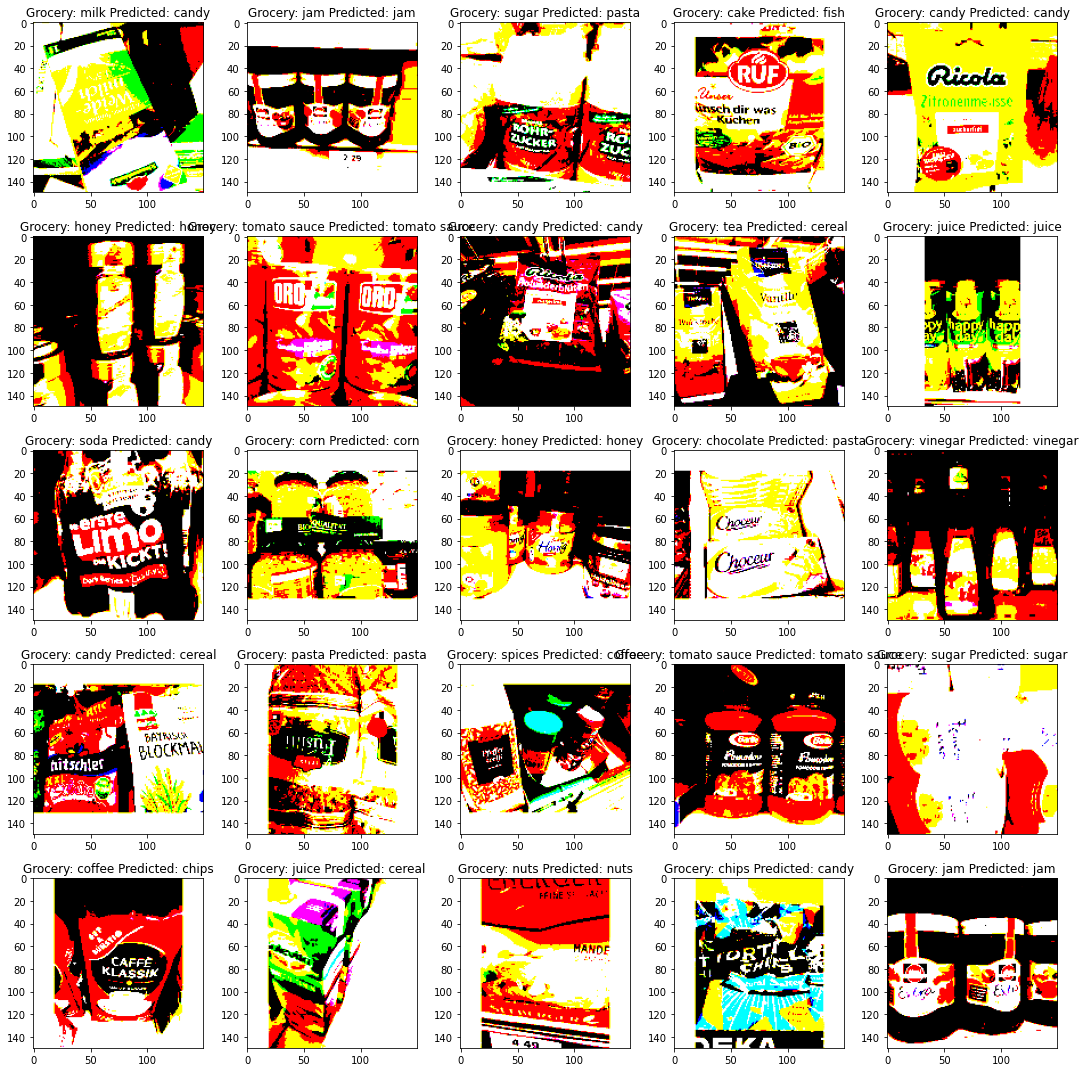

In [51]:
test_len = len(y_test)


fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(5):
        k = rn.randint(0, test_len)
        ax[i,j].imshow(x_test[k])
        ax[i,j].set_title('Grocery: '+ classes_names[np.argmax(y_test[k])] + " Predicted: " + classes_names[np.argmax(model.predict(x_test[k:k+1]))])
plt.tight_layout()  